# Merged model evaluation

In [18]:
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.scripts.atlas_paper.evaluate_atlas as ea
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np
import seaborn as sns
import re
import FusionModel.scripts.ari_group_prior as ag
import scipy.stats as stats
import PcmPy as pcm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itertools import combinations_with_replacement




In [19]:
# ---- Load results ----
with open(f'{ut.model_dir}/Models/Evaluation/nettekoven_68/ARI_granularity.npy', 'rb') as f:
    aris = np.load(f)

# Normalize aris by within-dataset reliability
ARI_avg = ea.average_comp_matrix(aris)
ARI_norm, aris_norm = ea.norm_comp_matrix(aris, ARI_avg)


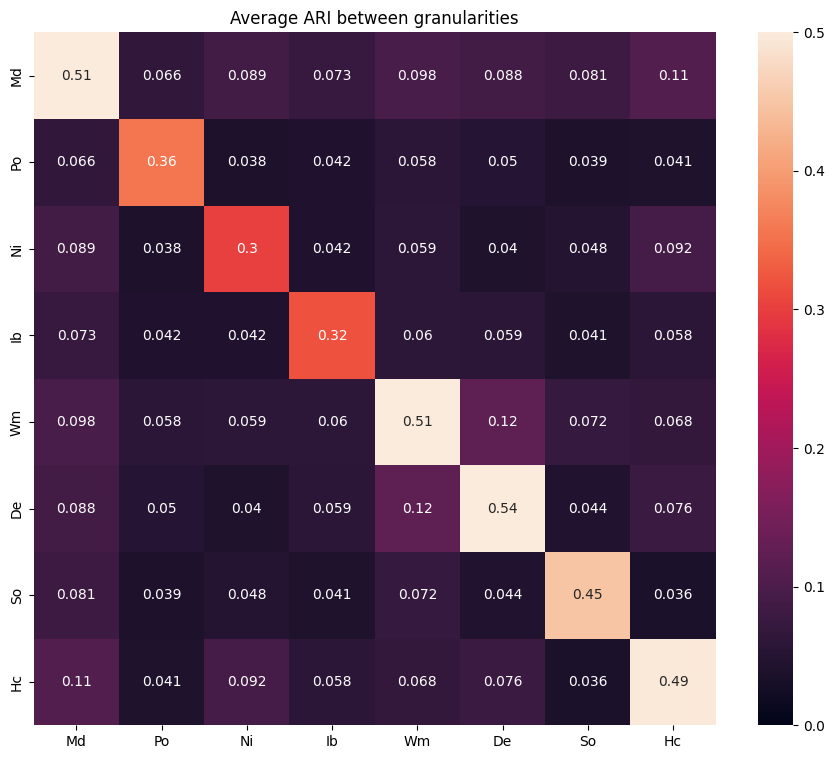

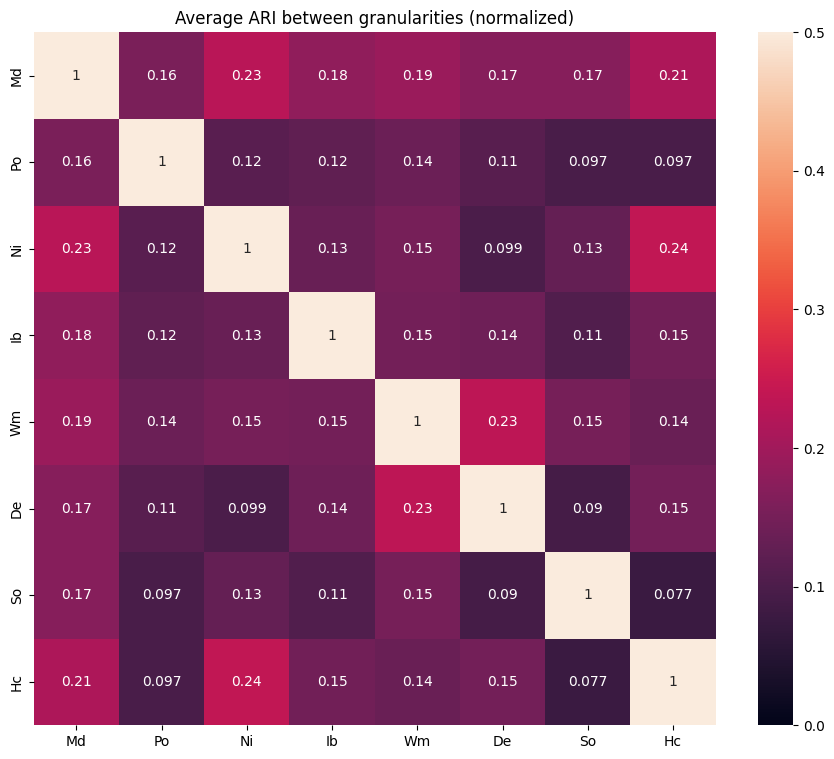

In [20]:
# ---- Plots ----
dataset_labels = ['Md', 'Po', 'Ni', 'Ib',
                    'Wm', 'De', 'So', 'Hc']

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(ARI_avg, annot=True, vmin=0, vmax=0.5, ax=ax,
            xticklabels=dataset_labels, yticklabels=dataset_labels)
plt.title('Average ARI between granularities')
plt.show()

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(ARI_norm, annot=True, vmin=0, vmax=0.5, ax=ax,
            xticklabels=dataset_labels, yticklabels=dataset_labels)
plt.title('Average ARI between granularities (normalized)')
plt.show()



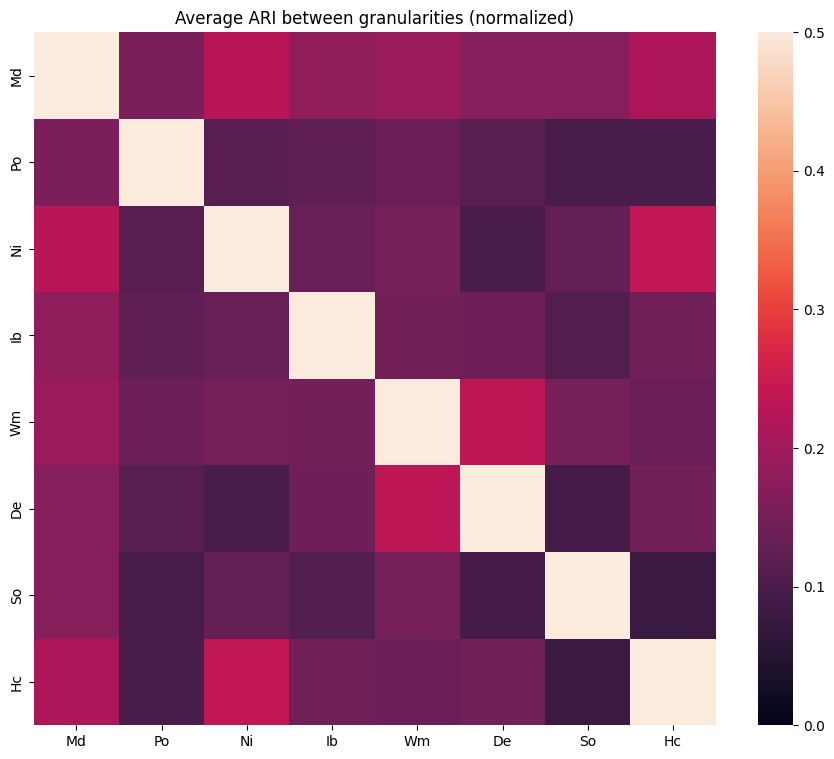

In [21]:
# ---- Plots ----
dataset_labels = ['Md', 'Po', 'Ni', 'Ib',
                  'Wm', 'De', 'So', 'Hc']


fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(ARI_norm, vmin=0, vmax=0.5, ax=ax,
            xticklabels=dataset_labels, yticklabels=dataset_labels)
plt.title('Average ARI between granularities (normalized)')
plt.show()


/Users/callithrix/Documents/Projects/Functional_Fusion/code/env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1174: RuntimeWarning:

All-NaN axis encountered

/Users/callithrix/Documents/Projects/Functional_Fusion/code/env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1175: RuntimeWarning:

All-NaN axis encountered



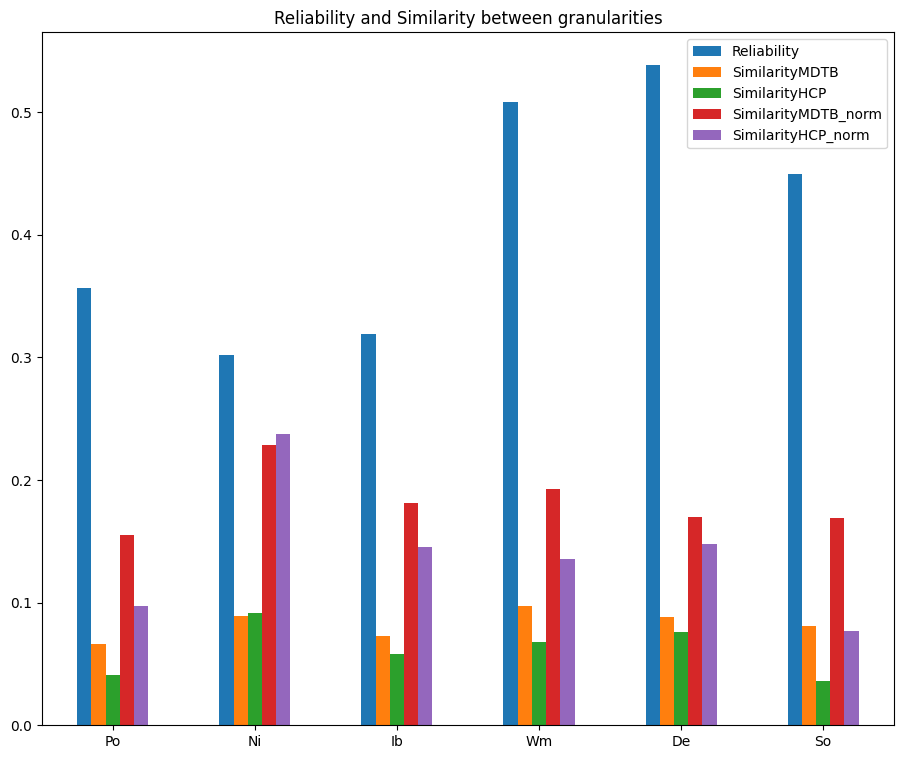

/Users/callithrix/Documents/Projects/Functional_Fusion/code/env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1174: RuntimeWarning:

All-NaN axis encountered

/Users/callithrix/Documents/Projects/Functional_Fusion/code/env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1175: RuntimeWarning:

All-NaN axis encountered



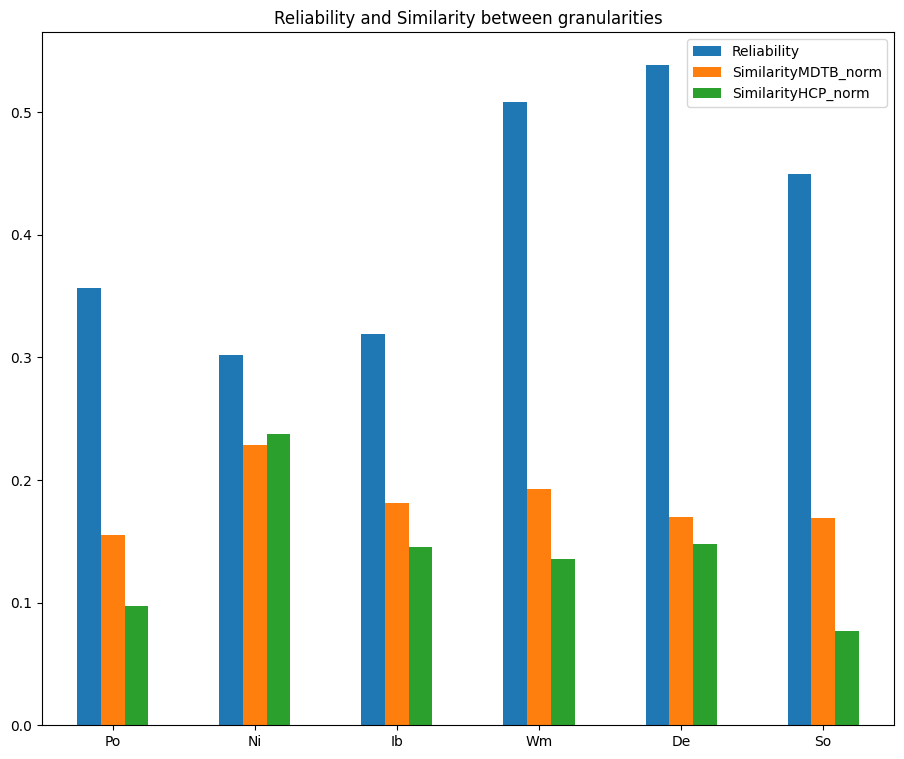

In [22]:
# Bar Plot of ARI_norm


# Make dataframe with reliability and similarity where indices are dataset_labels
df = pd.DataFrame({'Reliability': ARI_avg.diagonal(), 'SimilarityMDTB': ARI_avg[0], 'SimilarityHCP': ARI_avg[-1], 'SimilarityMDTB_norm': ARI_norm[0], 'SimilarityHCP_norm': ARI_norm[-1]},
                    index=dataset_labels)
# Plot as bar plots
ax = df.iloc[1:-1].plot.bar(rot=0, yerr=df.sem(axis=0), figsize=(11, 9))
plt.title('Reliability and Similarity between granularities')
plt.show()
df.head()

# Plot Reliability and normalized Similarity
ax = df.iloc[1:-1][['Reliability', 'SimilarityMDTB_norm', 'SimilarityHCP_norm']
                   ].plot.bar(rot=0, yerr=df.sem(axis=0), figsize=(11, 9))
plt.title('Reliability and Similarity between granularities')
plt.show()

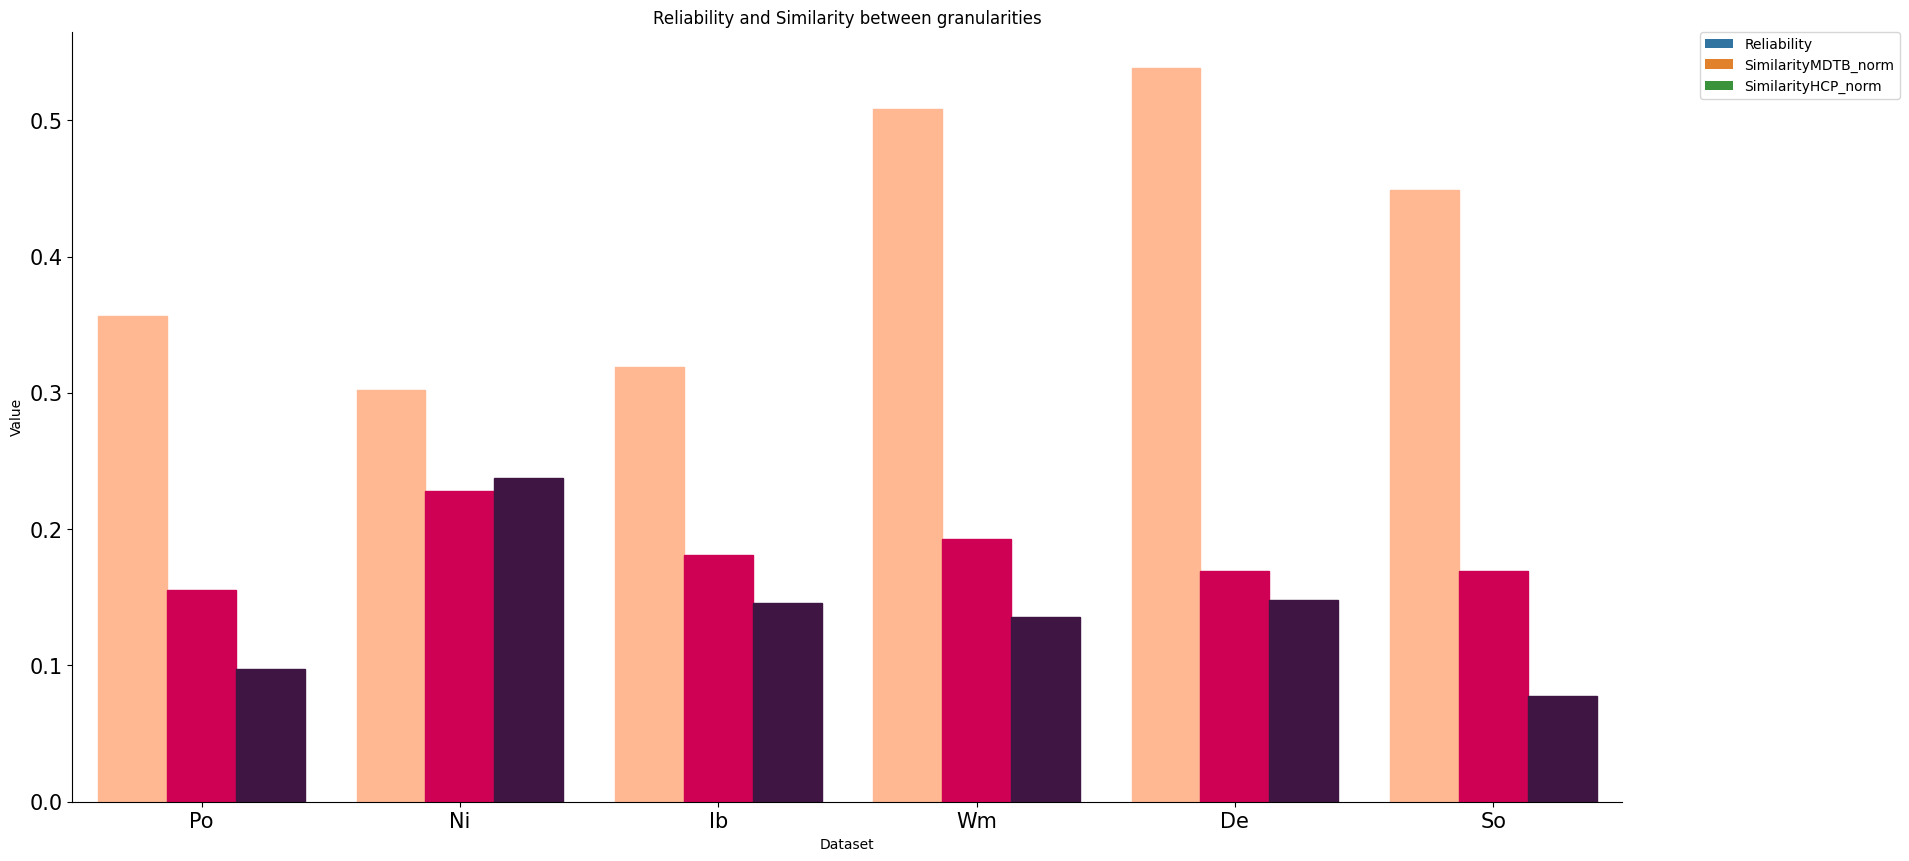

In [44]:
# Plot Reliability and normalized Similarity into separate bar plots with seaborn with dataset on x axis
df_melt = df.iloc[1:-1][['Reliability', 'SimilarityMDTB_norm', 'SimilarityHCP_norm']].reset_index().melt(
    id_vars='index', var_name='Measure', value_name='Value')

plt.figure(figsize=(20, 10))
ax = sns.barplot(x='index', y='Value', hue='Measure', data=df_melt)
# Make layout
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel('Dataset')
ax.set_ylabel('Value')
plt.title('Reliability and Similarity between granularities')
# Legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Ticks bigger
plt.tick_params(axis='both', which='major', labelsize=15)
# Set bar colours to hex value
colour_palette = ['FFB892', 'CF0154', '3F1643']

# Set colours
colour_palette = np.repeat(colour_palette, len(df_melt['index'].unique()))
for i, bar in enumerate(ax.patches):
    bar.set_color(f'#{colour_palette[i]}')
plt.show()
plt.savefig


In [9]:

# ---- Stats ----
# Test whether task based datasets are more similar to MDTB than to HCP
n_parcellations = int(np.sqrt(len(aris)))
mdtb_row = dataset_labels.index('Md')
hcp_row = dataset_labels.index('Hc')

mdtb_values = [aris_norm[i * n_parcellations + j]
               for j in np.arange(n_parcellations) for i in np.arange(n_parcellations) if i == mdtb_row and j != mdtb_row and j < hcp_row]
mdtb_values = [el for arr in mdtb_values for row in arr for el in row]

hcp_values = [aris_norm[i * n_parcellations + j]
              for j in np.arange(hcp_row) for i in np.arange(n_parcellations) if i == hcp_row and j <= hcp_row and j != mdtb_row  ]
hcp_values = [el for arr in hcp_values for row in arr for el in row]

task_values = [aris_norm[i * n_parcellations + j]
               for j in np.arange(hcp_row) for i in np.arange(j + 1, hcp_row) if i != j]
task_values = [el for arr in task_values for row in arr for el in row]

print(stats.ttest_rel(mdtb_values, hcp_values))
print(np.mean(mdtb_values), np.mean(hcp_values))
print(stats.ttest_ind(task_values, hcp_values))
print(np.mean(task_values), np.mean(hcp_values))

# Print degrees of freedom
result = stats.ttest_rel(mdtb_values, hcp_values)
print(result.statistic, result.pvalue)
print(len(mdtb_values) - 1)


Ttest_relResult(statistic=9.604928265049354, pvalue=2.671600189338409e-17)
0.18265052036496607 0.14020138927947967
Ttest_indResult(statistic=1.0397972995146159, pvalue=0.2988074912272632)
0.14624365220917676 0.14020138927947967
9.604928265049354 2.671600189338409e-17
149


In [10]:
# ---- PCM MDS ----
# Make mask that excludes HCP and MDTB rows/columns
dataset_labels = ['Md', 'Po', 'Ni', 'Ib',
                  'Wm', 'De', 'So', 'Hc']
mdtb_row = dataset_labels.index('Md')
hcp_row = dataset_labels.index('Hc')

mask = np.ones_like(ARI_norm, dtype=bool)

mask[hcp_row, :] = False
mask[mdtb_row, :] = False
mask[:, hcp_row] = False
mask[:, mdtb_row] = False

W, Glam = pcm.util.classical_mds(ARI_norm, contrast=mask)


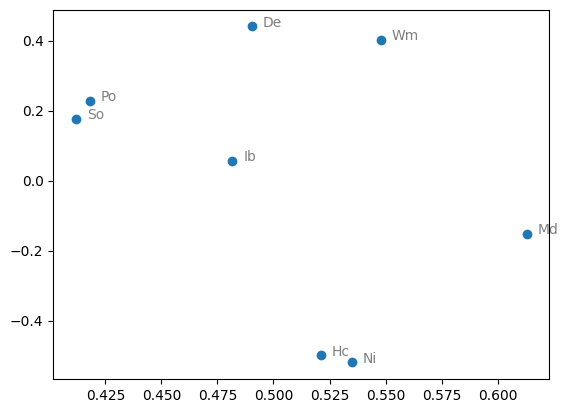

In [11]:
# ---- PCM MDS Plot ----
# Plot 2D MDS

plt.figure()
plt.scatter(W[:, 0], W[:, 1])
for j in range(W.shape[0]):
    plt.text(W[j, 0] + 0.005, W[j, 1], dataset_labels[j],
                fontdict=dict(alpha=0.5))
plt.show()


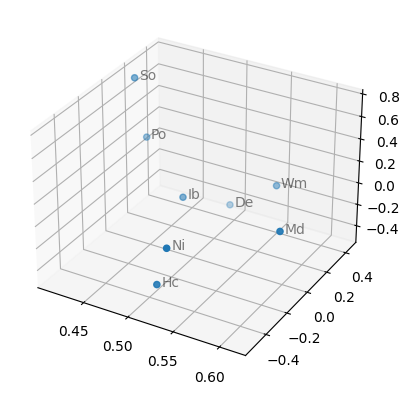

In [12]:

# Plot 3D MDS

# Choose the three eigenvectors with the highest eigenvalues
# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(W[:, 0], W[:, 1], W[:, 2])
for j in range(W.shape[0]):
    ax.text(W[j, 0] + 0.005, W[j, 1], W[j, 2], dataset_labels[j],
            fontdict=dict(alpha=0.5))


## MDS Plot with contrast masking out MDTB & HCP contribution

In [13]:

x_data = W[:, 0]
y_data = W[:, 1]
z_data = W[:, 2]
# Colour first and last point differently from the rest
color = ['rgb(0, 0, 0)'] * len(x_data) # Set color to black
color[0] = 'rgb(255, 0, 0)' # First point is red
color[-1] = 'rgb(0, 0, 255)' # Last point is blue



fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
fig.add_trace(go.Scatter3d(
    x=x_data,
    y=y_data,
    z=z_data,
    mode='markers+text',
    marker=dict(
        size=5,
        color=color,
        opacity=0.8
    ),
    text=dataset_labels,  # Set the text labels
    textposition='top center'  # Set the position of the text labels
))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    # autosize=False,
    # width=1000,
    # height=1000,
)
fig.show()
fig.write_image("images/3d_mds.pdf")

## MDS Plot with no contrast

In [14]:
# ---- PCM MDS without Contrast (decomposition based on all datasets, incl MDTB & HCP) ----
W_all, Glam_all = pcm.util.classical_mds(ARI_norm)

x_all = W_all[:, 0]
y_all = W_all[:, 1]
z_all = W_all[:, 2]
# Colour first and last point differently from the rest
color = ['rgb(0, 0, 0)'] * len(x_data)  # Set color to black
color[0] = 'rgb(255, 0, 0)'  # First point is red
color[-1] = 'rgb(0, 0, 255)'  # Last point is blue


fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
fig.add_trace(go.Scatter3d(
    x=x_all,
    y=y_all,
    z=z_all,
    mode='markers+text',
    marker=dict(
        size=5,
        color=color,
        opacity=0.8
    ),
    text=dataset_labels,  # Set the text labels
    textposition='top center'  # Set the position of the text labels
))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0)
)
fig.show()
